## Testing W/ XGBoost model

This was a test to see if removing the datasets of potential anomalies from the original data would improve model performance of a basic XGBoost model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.impute import SimpleImputer


In [2]:
data_big = pd.read_csv('WOWTDR_prepdat.csv')

In [3]:
file_names = ['anomalies_0.csv','anomalies_1.csv','anomalies_2.csv',
             'anomalies_3.csv','anomalies_4.csv','anomalies_5.csv',
             'anomalies_6.csv','anomalies_7.csv','anomalies_8.csv',
             'anomalies_9.csv','anomalies_10.csv','anomalies_11.csv',
             'anomalies_12.csv','anomalies_13.csv','anomalies_14.csv',
              'anomalies_15.csv','anomalies_16.csv','anomalies_17.csv',
              'anomalies_18.csv','anomalies_19.csv','anomalies_20.csv']

In [19]:
file_names2 = ['anomalies_21.csv','anomalies_22.csv','anomalies_23.csv',
             'anomalies_24.csv','anomalies_25.csv','anomalies_26.csv',
             'anomalies_27.csv','anomalies_28.csv','anomalies_29.csv',
             'anomalies_30.csv','anomalies_31.csv','anomalies_32.csv',
             'anomalies_33.csv','anomalies_34.csv','anomalies_35.csv',
              'anomalies_36.csv','anomalies_37.csv','anomalies_38.csv',
              'anomalies_39.csv','anomalies_40.csv','anomalies_41.csv']

In [4]:
anomalies = []
for file_name in file_names:
    anoms = pd.read_csv(file_name,index_col=0)
    anomalies.append(anoms)

In [20]:
anomalies2 = []
for file_name in file_names2:
    anoms = pd.read_csv(file_name,index_col=0)
    anomalies2.append(anoms)

In [23]:
anomalies2[0]

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,anomaly
10,1531,Dry,0.922550,337.325928,0.082200,773.649902,3.141267,0.031730,2,2.880284,-1
11,1532,Dry,4.051450,354.428833,0.020584,776.714722,3.090779,0.050379,3,16.954465,-1
14,1535,Dry,0.194775,580.066772,0.240352,854.779968,0.813101,0.015881,1,0.614257,-1
32,1553,Dry,0.080375,1309.911865,0.008850,1401.169312,39.272629,-0.006201,1,0.085975,-1
127,1648,Wet,0.047575,637.371765,0.285044,764.317017,0.801813,0.239753,1,0.007271,-1
...,...,...,...,...,...,...,...,...,...,...,...
2779,115,Dry,10.966374,889.170593,0.014840,3062.299805,24.996820,-0.013110,4,24.636546,-1
2789,232,Wet,5.608425,1669.413940,0.270914,3118.552002,25.235018,2.473441,3,15.008474,-1
2909,1812,Wet,17.885399,151.599915,0.015810,1805.328979,8.606834,0.024246,5,111.203313,-1
2910,1816,Wet,17.038774,154.836578,0.010553,1904.492065,10.698414,0.006610,5,107.411083,-1


In [6]:
accuracy_scores = []
for i in range(len(anomalies)):
    data = data_big[['ID', 'obs','FAC_sqkm', 'elev','d_slp20_m', 'ppt_sum_yr_m_0', 'ppt_yr_m_0', 'seg_slope_perc', 'STRAHLER', 'SumUpSlpLen_km']]

    data = data.drop(anomalies[i].index)

    data.obs[data.obs=='Wet']=1
    data.obs[data.obs=='Dry']=0

    data['obs']=data.obs.apply(pd.to_numeric)
    
    X = data.drop(['obs','ID'],axis=1)
    y = data['obs']

    X_train,X_test,y_train,y_test = train_test_split(X,y)

    numerical_feats = ['FAC_sqkm','elev','d_slp20_m','ppt_sum_yr_m_0','ppt_yr_m_0','seg_slope_perc','SumUpSlpLen_km']
    categorical_feats = ['STRAHLER']
    
    num_processor = Pipeline(steps=[
    ('scaler', StandardScaler())  ])
    
    feat_processor = ColumnTransformer(transformers = [
    ('num_pipe', num_processor,numerical_feats)],remainder='drop')
    
    clf= xgb.XGBClassifier()

    pipe = Pipeline(steps=[
        ('feature_processor', feat_processor),
        ('clf', clf)
    ])
    pipe

    pipe.fit(X_train,y_train)
    
    parameters = {"clf__min_samples_leaf" : [1, 4,  8], # default 1
              "clf__min_samples_split" : [2, 4, 8], # default 2
              "clf__n_estimators" : [10, 25, 50, 100, 150], # default 100
              "clf__max_depth" : [2,5,10,15,20]} # default None (unlimited)

    grid = GridSearchCV(pipe, parameters,cv=5,scoring='accuracy',n_jobs=-1,verbose=True)
    grid.fit(X_train,y_train)
    
    best_clf=grid.best_estimator_
    
    y_test_pred = best_clf.predict(X_test)
    
    accuracy_scores.append(accuracy_score(y_test,y_test_pred))
    
    

C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:18:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:19:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:20:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:23:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:27:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:28:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\1287405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[20:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



In [24]:
accuracy_scores2 = []
for i in range(len(anomalies2)):
    data = data_big[['ID', 'obs','FAC_sqkm', 'elev','d_slp20_m', 'ppt_sum_yr_m_0', 'ppt_yr_m_0', 'seg_slope_perc', 'STRAHLER', 'SumUpSlpLen_km']]

    data = data.drop(anomalies2[i].index)

    data.obs[data.obs=='Wet']=1
    data.obs[data.obs=='Dry']=0

    data['obs']=data.obs.apply(pd.to_numeric)
    
    X = data.drop(['obs','ID'],axis=1)
    y = data['obs']

    X_train,X_test,y_train,y_test = train_test_split(X,y)

    numerical_feats = ['FAC_sqkm','elev','d_slp20_m','ppt_sum_yr_m_0','ppt_yr_m_0','seg_slope_perc','SumUpSlpLen_km']
    categorical_feats = ['STRAHLER']
    
    num_processor = Pipeline(steps=[
    ('scaler', StandardScaler())  ])
    
    feat_processor = ColumnTransformer(transformers = [
    ('num_pipe', num_processor,numerical_feats)],remainder='drop')
    
    clf= xgb.XGBClassifier()

    pipe = Pipeline(steps=[
        ('feature_processor', feat_processor),
        ('clf', clf)
    ])
    pipe

    pipe.fit(X_train,y_train)
    
    parameters = {"clf__min_samples_leaf" : [1, 4,  8], # default 1
              "clf__min_samples_split" : [2, 4, 8], # default 2
              "clf__n_estimators" : [10, 25, 50, 100, 150], # default 100
              "clf__max_depth" : [2,5,10,15,20]} # default None (unlimited)

    grid = GridSearchCV(pipe, parameters,cv=5,scoring='accuracy',n_jobs=-1,verbose=True)
    grid.fit(X_train,y_train)
    
    best_clf=grid.best_estimator_
    
    y_test_pred = best_clf.predict(X_test)
    
    accuracy_scores2.append(accuracy_score(y_test,y_test_pred))


C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:11:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:13:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:14:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


[21:15:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:16:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:17:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:18:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:19:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


[21:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:25:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_23124\2464107924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[21:26:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



Text(0, 0.5, 'accuracy')

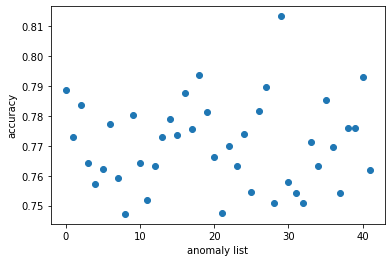

In [29]:
accuracy_scores_total = accuracy_scores + accuracy_scores2
anom_list_total = np.linspace(0,41,42)
plt.scatter(anom_list_total, accuracy_scores_total)
plt.xlabel('anomaly list')
plt.ylabel('accuracy')

It does not appear that removing the potential anomalies has any notable affect on model performance.